In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

ImportError: No module named 'pmdarima.__check_build._check_build'
___________________________________________________________________________
Contents of C:\Users\DELL\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\__check_build:
setup.py                  tests                     _check_build.cp37-win_amd64.pyd
__init__.py               __pycache__
___________________________________________________________________________
It seems that pmdarima has not been built correctly.
If you have installed pmdarima from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` from the top-level directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [3]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load datasets
df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [5]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [6]:
df = df.dropna()
df.shape

(252, 2)

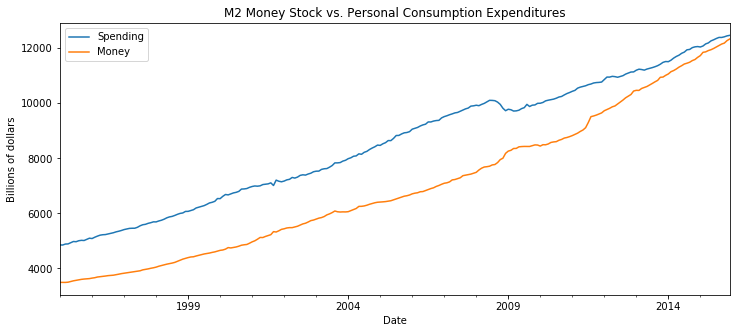

In [7]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

## Test for stationarity, perform any necessary transformations
In the previous section we applied the augmented Dickey-Fuller test and found that a second-order difference achieved stationarity. In this section we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders.

<div class="alert alert-info"><strong>NOTE: </strong> When performing the auto_arima function we're likely to see a <tt><font color=black>ConvergenceWarning: Maximum Likelihood optimization failed to converge.</font></tt> This is not unusual in models which have to estimate a large number of parameters. However, we can override the maximum iterations default of 50, and pass an arbitrarily large number with <tt>maxiter=1000</tt>. We'll see this come up again when we fit our model.</div> 

In [9]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 2, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [10]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

- In order, middle term is different for both of them above, this means that the middle terms has to be differenced because middle term is the I term
- Recall that VARMA is not going to be able to differenced, because there is no I term in "VARMA"

- But, values of p and q are out now, i.e. 1 and 2 respectively

It looks like a VARMA(1,2) model is recommended. Note that the  𝑑  term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [11]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [12]:
len(df_transformed)

250

# Test-Train split

In [13]:
nobs=12
train, test = df_transformed[:-nobs], df_transformed[-nobs:]

In [14]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


# Fit the VARMA(1,2) model

In [16]:
model=VARMAX(train,order=(1,2),trend='c')   # trend='c' tells us that we want a costant linear trend
results=model.fit(maxiter=1000,disp=False)   #disp=False inhibits some massages to be shown when disp=True
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.286
,+ intercept,AIC,4606.571
Date:,"Sun, 13 Jun 2021",BIC,4665.600
Time:,17:14:01,HQIC,4630.361
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.42, 28.14",Jarque-Bera (JB):,"547.62, 120.94"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.61, 2.91",Skew:,"1.33, -0.34"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [17]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.501568,36.789494
2015-02-01,-10.883687,-4.696517
2015-03-01,1.124754,-0.222204
2015-04-01,-1.413346,-0.379833
2015-05-01,0.889492,0.180924
2015-06-01,-0.263555,-0.048266
2015-07-01,0.429407,0.101016
2015-08-01,0.038821,0.019025
2015-09-01,0.263797,0.066679
2015-10-01,0.135170,0.039517


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [18]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [19]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [20]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.501568,36.789494,67.098432,11658.598432,47.389494,12098.789494
2015-02-01,-10.883687,-4.696517,56.214745,11647.714745,42.692977,12094.092977
2015-03-01,1.124754,-0.222204,57.339499,11648.839499,42.470773,12093.870773
2015-04-01,-1.413346,-0.379833,55.926154,11647.426154,42.090940,12093.490940
2015-05-01,0.889492,0.180924,56.815646,11648.315646,42.271865,12093.671865
2015-06-01,-0.263555,-0.048266,56.552091,11648.052091,42.223598,12093.623598
2015-07-01,0.429407,0.101016,56.981498,11648.481498,42.324614,12093.724614
2015-08-01,0.038821,0.019025,57.020319,11648.520319,42.343640,12093.743640
2015-09-01,0.263797,0.066679,57.284116,11648.784116,42.410319,12093.810319
2015-10-01,0.135170,0.039517,57.419286,11648.919286,42.449836,12093.849836


In [22]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

#The concat() function (in the main pandas namespace) does all of the heavy lifting of performing concatenation operations 
#   along an axis while performing optional set logic (union or intersection) of the indexes (if any) on the other axes. 
#   Note that I say “if any” because there is only a single possible axis of concatenation for Series.

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.598432,12098.789494
2015-02-01,11852.4,12082.4,11647.714745,12094.092977
2015-03-01,11868.8,12158.3,11648.839499,12093.870773
2015-04-01,11916.1,12193.8,11647.426154,12093.490940
2015-05-01,11947.6,12268.1,11648.315646,12093.671865
2015-06-01,11993.1,12308.3,11648.052091,12093.623598
2015-07-01,12045.3,12355.4,11648.481498,12093.724614
2015-08-01,12096.8,12394.0,11648.520319,12093.743640
2015-09-01,12153.8,12392.8,11648.784116,12093.810319


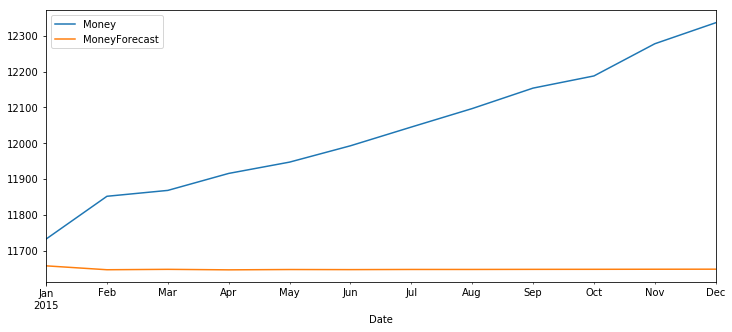

In [23]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

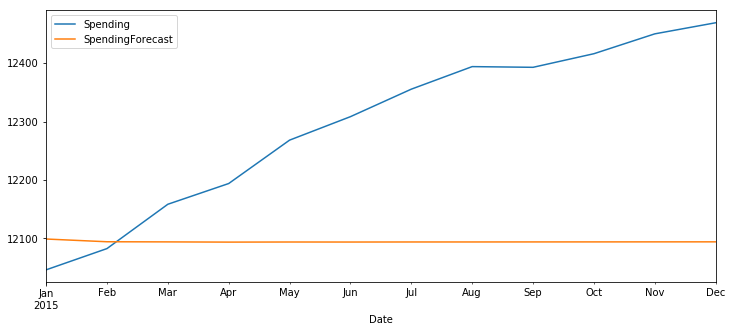

In [24]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [25]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 422.942


In [27]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 243.777


Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(1,2) models

# Money

In [30]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [31]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.214
Date:                Sun, 13 Jun 2021   AIC                           2245.421
Time:                        17:29:05   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.218      0.225      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.573      0.117      -0.918       0.101
ma.L2.Money    -0.5912      0.259     -2.278      0.024      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8022           +0.0000j            2.8022            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [32]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [33]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [34]:
z1

,Money
2015-01-01,-14.498910
2015-02-01,-10.947218
2015-03-01,4.152839
2015-04-01,-1.235882
2015-05-01,0.687178
2015-06-01,0.000900
2015-07-01,0.245811
2015-08-01,0.158410
2015-09-01,0.189600
2015-10-01,0.178470


### Invert the Transformation, Evaluate the Forecast

In [35]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [36]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498910,64.101090,11734.201090
2015-02-01,-10.947218,53.153872,11787.354962
2015-03-01,4.152839,57.306711,11844.661673
2015-04-01,-1.235882,56.070829,11900.732502
2015-05-01,0.687178,56.758007,11957.490509
2015-06-01,0.000900,56.758908,12014.249417
2015-07-01,0.245811,57.004718,12071.254135
2015-08-01,0.158410,57.163128,12128.417263
2015-09-01,0.189600,57.352729,12185.769991
2015-10-01,0.178470,57.531198,12243.301190


In [37]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 422.942
Money  ARMA(1,2) RMSE: 32.236


# Spending

In [38]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Sun, 13 Jun 2021   AIC                           2374.823
Time:                        17:31:59   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.727      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.506      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.217      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.660      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1438           +0.0000j            4.1438            0.5000
-----------------------------------------------------------------------------
"""

In [39]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555831
2015-02-01,-3.338262
2015-03-01,1.250702
2015-04-01,-0.310832
2015-05-01,0.220527
2015-06-01,0.039716
2015-07-01,0.101243
2015-08-01,0.080306
2015-09-01,0.087431
2015-10-01,0.085006


In [40]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [41]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555831,44.155831,12106.155831
2015-02-01,-3.338262,40.817569,12146.973400
2015-03-01,1.250702,42.068270,12189.041670
2015-04-01,-0.310832,41.757439,12230.799108
2015-05-01,0.220527,41.977966,12272.777074
2015-06-01,0.039716,42.017682,12314.794756
2015-07-01,0.101243,42.118925,12356.913681
2015-08-01,0.080306,42.199231,12399.112912
2015-09-01,0.087431,42.286662,12441.399574
2015-10-01,0.085006,42.371668,12483.771242


In [42]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 243.777
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.